# Setup

In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
import torch
import matplotlib.pyplot as plt
from FittedModels.utils import plot_distributions
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
#from TargetDistributions.BayesianNN import PosteriorBNN
from TargetDistributions.Fast_BNN import FastPosteriorBNN as PosteriorBNN
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.utils import plot_distributions, plot_history, plot_samples, plot_sampling_info, plot_divergences
from FittedModels.train import LearntDistributionManager
from Utils.numerical_utils import MC_estimate_true_expectation, expectation_function
from Utils.plotting_utils import plot_distribution, plot_func2D

# Easy BNN Problem

## Specifiy target distribution and key param

In [3]:
torch.manual_seed(1)
target = PosteriorBNN(n_datapoints=2, x_dim=1, y_dim=1, n_hidden_layers=0, layer_width=0
                             ,linear_activations=True, fixed_variance=True, use_bias=True)

changing model batch size to 10000 (note that tihs will be occuring often if this message comes up during training


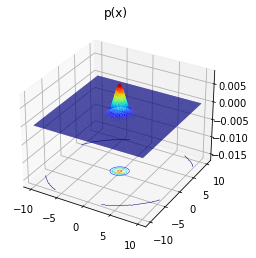

In [4]:
p_x_fig = plot_distribution(target, n_points=100)

## Setup

In [5]:
epochs = 1000
n_samples_estimation = int(1e4)
dim = target.n_parameters
print(dim)

2


## DReG
Let's instantiate a flow based model, and train using DReG

In [6]:
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

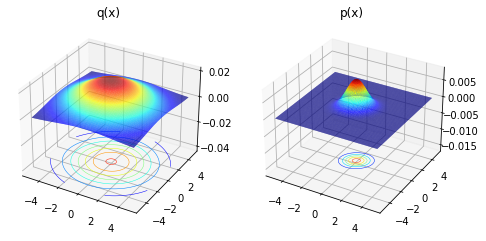

In [7]:
fig_before_train = plot_distributions(tester, bounds=[[-5, 5], [-5, 5]])

In [8]:
history = tester.train(400, batch_size=100)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: 3.0560803413391113, mean log p_x -6.361068248748779: 100%|█████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:16<00:00,  2.94it/s]


(<Figure size 432x720 with 8 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>],
       dtype=object))

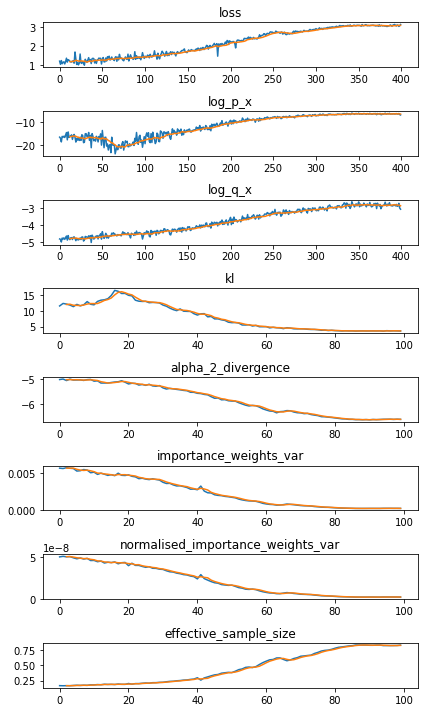

In [9]:
plot_history(history) #, bounds=[-1e4, 0])

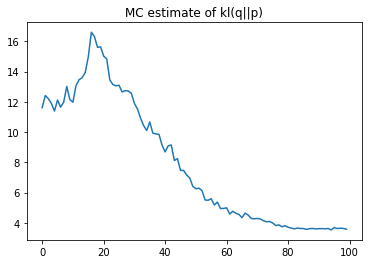

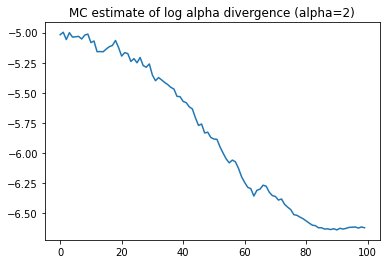

In [10]:
plot_divergences(history)

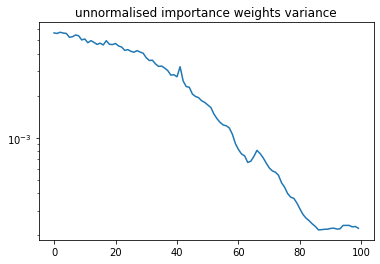

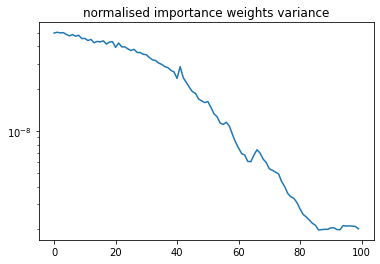

In [11]:
plot_sampling_info(history)

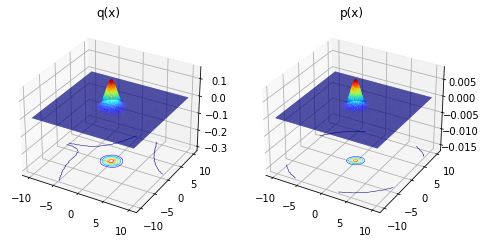

In [12]:
fig_after_train = plot_distributions(tester)

In [13]:
print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
      f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation} \n"
     f"effective sample size after is {info['effective_sample_size']} out of {n_samples_estimation}  \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 1.6253563165664673 
estimate after training is 1.5993813276290894 
effective sample size before is 1604.8616943359375 out of 10000 
effective sample size after is 8247.3779296875 out of 10000  
variance in weights is 2.1252777315794447e-09


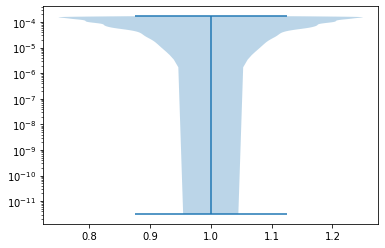

In [14]:
plt.violinplot([info['normalised_sampling_weights']])
plt.yscale("log")

## KL

In [15]:
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [16]:
history = tester.train(1000, batch_size=1000) #epochs
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: 3.486020088195801, mean log p_x -5.715719699859619: 100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:14<00:00,  5.13it/s]


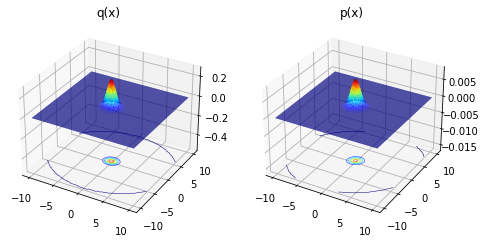

In [17]:
fig_after_train = plot_distributions(tester)

(<Figure size 432x720 with 8 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>],
       dtype=object))

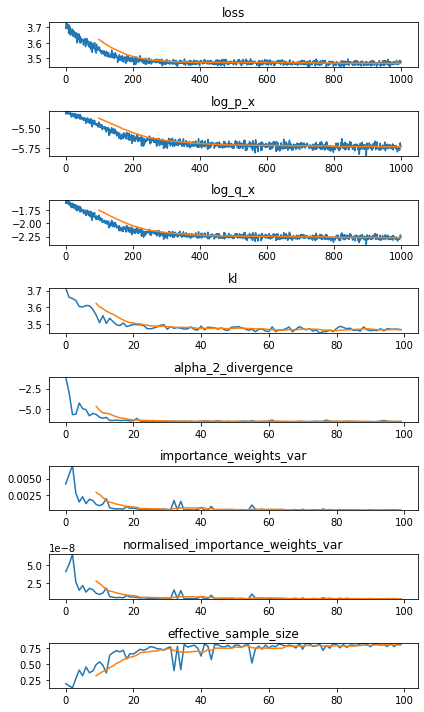

In [18]:
plot_history(history, bounds=[-1e12, 1e12], running_chunk_n=10)

In [19]:
print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
      f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation} \n"
     f"effective sample size after is {info['effective_sample_size']} out of {n_samples_estimation}  \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 1.334033489227295 
estimate after training is 1.5164389610290527 
effective sample size before is 1604.8616943359375 out of 10000 
effective sample size after is 8107.1669921875 out of 10000  
variance in weights is 2.3350024136448155e-09


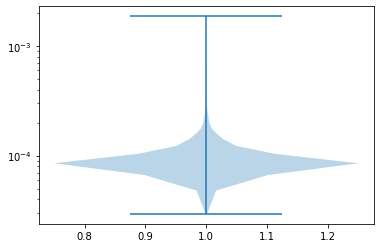

In [20]:
plt.violinplot([info['normalised_sampling_weights']])
plt.yscale("log")

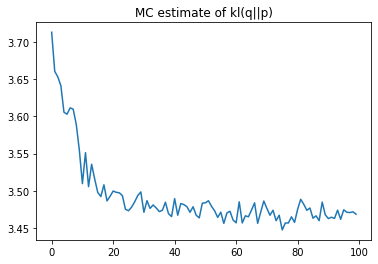

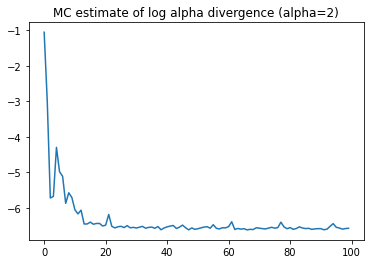

In [21]:
plot_divergences(history)

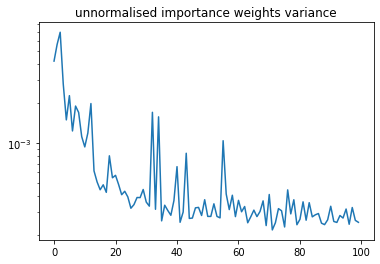

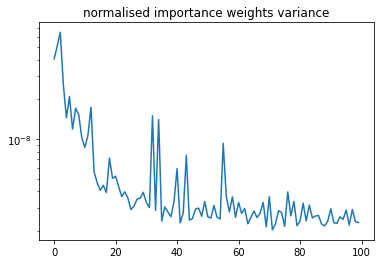

In [22]:
plot_sampling_info(history)

# Harder Problem

In [23]:
torch.manual_seed(1)
target = PosteriorBNN(n_datapoints=10, x_dim=1, y_dim=1, n_hidden_layers=1, layer_width=2, fixed_variance=True)
epochs = 1000
n_samples_estimation = int(1e4)
dim = target.n_parameters
print(dim)

7


## DReG
Let's instantiate a flow based model, and train using DReG

In [24]:
epochs = 500; batch_size = int(1e4)

In [25]:
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

changing model batch size to 10000 (note that tihs will be occuring often if this message comes up during training


In [26]:
history = tester.train(epochs, batch_size=batch_size, clip_grad=True, max_grad_norm=2)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: 17.645000457763672, mean log p_x -54.12446975708008: 100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [46:41<00:00,  5.60s/it]


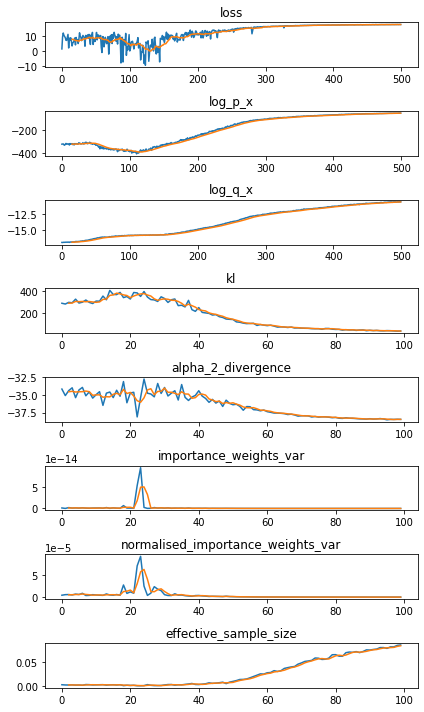

In [27]:
hist_plot = plot_history(history) #, bounds=[-1e4, 0])

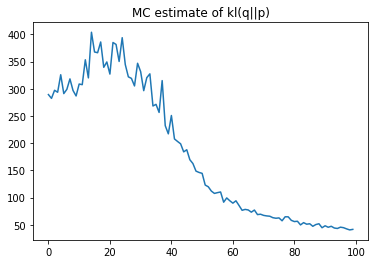

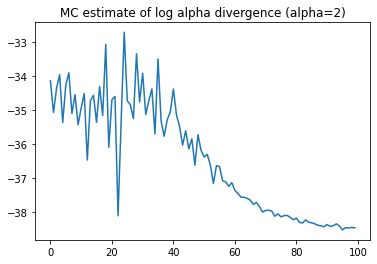

In [28]:
plot_divergences(history)

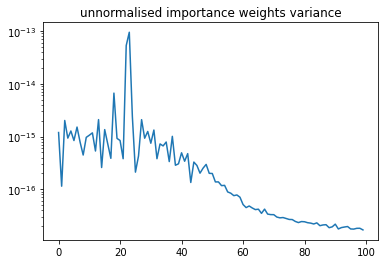

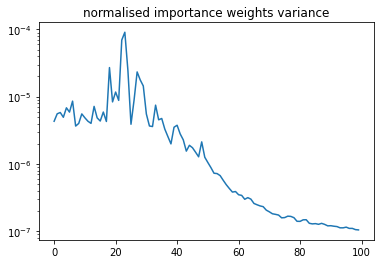

In [29]:
plot_sampling_info(history)

In [30]:
print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
      f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation} \n"
     f"effective sample size after is {info['effective_sample_size']} out of {n_samples_estimation}  \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 9.977568626403809 
estimate after training is 9.143640518188477 
effective sample size before is 14.62170124053955 out of 10000 
effective sample size after is 881.4725341796875 out of 10000  
variance in weights is 1.0345686973778356e-07


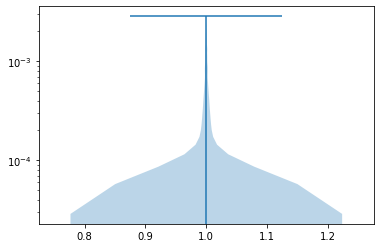

In [31]:
plt.violinplot([info['normalised_sampling_weights']])
plt.yscale("log")

## KL

In [32]:
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [33]:
history = tester.train(epochs, batch_size=batch_size)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: 29.071134567260742, mean log p_x -38.2364387512207: 100%|██████████████████████████████████████████████████████████████████████████████████████| 500/500 [37:41<00:00,  4.52s/it]


(<Figure size 432x720 with 8 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>,
        <AxesSubplot:title={'center':'effective_sample_size'}>],
       dtype=object))

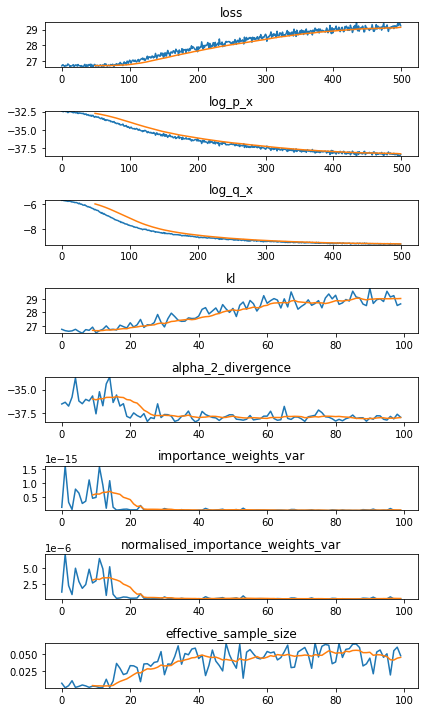

In [34]:
plot_history(history, bounds=[-1e12, 1e12], running_chunk_n=10)

In [35]:
print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
      f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation} \n"
     f"effective sample size after is {info['effective_sample_size']} out of {n_samples_estimation}  \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 6.488059043884277 
estimate after training is 8.901609420776367 
effective sample size before is 14.62170124053955 out of 10000 
effective sample size after is 600.44775390625 out of 10000  
variance in weights is 1.5655804475045443e-07


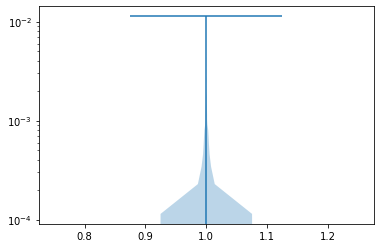

In [36]:
plt.violinplot([info['normalised_sampling_weights']])
plt.yscale("log")

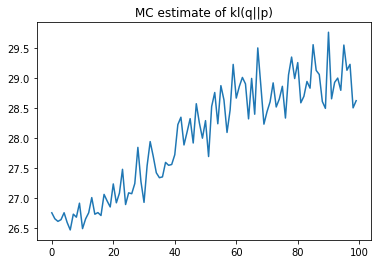

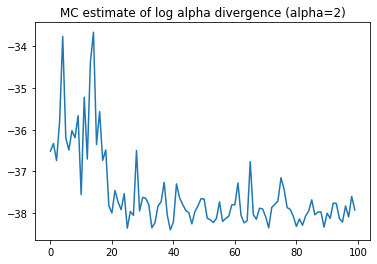

In [37]:
plot_divergences(history)

# Compare Fast BNN with original BNN

In [39]:
from TargetDistributions.BayesianNN import PosteriorBNN as OriginalPosteriorBNN
from TargetDistributions.Fast_BNN import FastPosteriorBNN as PosteriorBNN

In [40]:
torch.manual_seed(1)
target_fast = PosteriorBNN(n_datapoints=10, x_dim=1, y_dim=1, n_hidden_layers=1, layer_width=2, fixed_variance=True)
target_slow = OriginalPosteriorBNN(n_datapoints=10, x_dim=1, y_dim=1, n_hidden_layers=1, layer_width=2, fixed_variance=True)
epochs = 3
n_samples_estimation = int(10)
dim_fast = target_fast.n_parameters
dim_slow = target_slow.n_parameters
print(dim_fast)
print(dim_slow)

7
7


In [41]:
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target_fast, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
history = tester.train(3, batch_size=100) #epochs
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

  0%|                                                                                                                                                            | 0/3 [00:00<?, ?it/s]

changing model batch size to 100 (note that tihs will be occuring often if this message comes up during training


loss: 26.276927947998047, mean log p_x -31.899267196655273: 100%|████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.29s/it]


In [42]:
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target_slow, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
history = tester.train(3, batch_size=100) #epochs
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: 26.21939468383789, mean log p_x -32.14360046386719: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:29<00:00, 29.79s/it]


# New Section